In [4]:
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
import pandas as pd
from sklearn.feature_selection import chi2, mutual_info_classif
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

In [5]:
KFOLD = 5
NUM_FEATURES = 24866
MUTUAL_INFO_THRESH = 0.05

### Feature Selection

In [6]:
mutual_info = np.zeros((NUM_FEATURES,))
for i in range(KFOLD):
    print('Current fold: ', i)
    
    file = '../Dataset/tr_hw_fold_' + str(i) + '.pkl'
    tr_data = pd.read_pickle(file)
    
    kmeans = KMeans(n_clusters= 4, random_state= 0)
    clus_dist = kmeans.fit_transform(tr_data)
    labels = np.argmin(clus_dist, axis =1)
    
    mut_info_fold = mutual_info_classif(tr_data.iloc[:, : -2], labels)
    mutual_info += mut_info_fold


Current fold:  0
Current fold:  1
Current fold:  2
Current fold:  3
Current fold:  4


In [7]:
mutual_info /= KFOLD
print(mutual_info)


[0.09468649 0.12770621 0.0332575  ... 0.01472941 0.06737512 0.07624408]


In [8]:
selected_features = np.where(mutual_info > MUTUAL_INFO_THRESH)
selected_features = selected_features[0]
print(selected_features.shape)

(9833,)


In [10]:
with open('../Dataset/hw_selected_features.pkl', 'wb') as featurefile:
    pickle.dump(selected_features, featurefile)

In [11]:
ranked_features = np.argsort(mutual_info)[::-1]
ranked_features = tr_data.columns[ranked_features]
print(ranked_features)
with open('../Dataset/hw_ranked_features.pkl', 'wb') as featurefile:
    pickle.dump(ranked_features, featurefile)

Index(['JHI-Hv50k-2016-163759', 'JHI-Hv50k-2016-166560',
       'JHI-Hv50k-2016-166368', 'JHI-Hv50k-2016-163688',
       'JHI-Hv50k-2016-166576', 'JHI-Hv50k-2016-167734', 'SCRI_RS_906',
       'JHI-Hv50k-2016-163691', 'JHI-Hv50k-2016-163731',
       'JHI-Hv50k-2016-163732',
       ...
       'JHI-Hv50k-2016-429585', 'JHI-Hv50k-2016-216958',
       'JHI-Hv50k-2016-214092', 'BOPA1_ConsensusGBS0371-2', 'SCRI_RS_210006',
       'JHI-Hv50k-2016-46770', 'JHI-Hv50k-2016-261184', 'SCRI_RS_169904',
       'JHI-Hv50k-2016-273856', 'JHI-Hv50k-2016-452632'],
      dtype='object', length=24866)


In [12]:
tr_data.iloc[:, selected_features].head(5)

,BK_05,BK_08,BOPA1_10012-1239,BOPA1_10126-999,BOPA1_10248-954,BOPA1_10317-448,BOPA1_10321-364,BOPA1_1040-279,BOPA1_1041-1441,BOPA1_10425-725,...,SCRI_RS_9350,SCRI_RS_9455,SCRI_RS_9469,SCRI_RS_9560,SCRI_RS_98293,SCRI_RS_98443,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_9980,SCRI_RS_9991
0,0.506667,0.665811,0.694444,0.509142,0.796308,0.197531,0.815008,0.898546,0.833924,0.403754,...,0.373457,0.632246,0.833924,0.741512,0.856267,0.5625,0.475046,0.796308,0.853057,0.077160
1,0.083056,0.033866,0.027778,0.082058,0.011586,0.308642,0.815008,0.898546,0.833924,0.132921,...,0.373457,0.632246,0.833924,0.019290,0.856267,0.5625,0.475046,0.796308,0.853057,0.521605
2,0.506667,0.665811,0.694444,0.509142,0.796308,0.308642,0.815008,0.898546,0.833924,0.132921,...,0.151235,0.632246,0.833924,0.741512,0.856267,0.5625,0.475046,0.011586,0.853057,0.521605
3,0.083056,0.033866,0.694444,0.509142,0.796308,0.197531,0.815008,0.898546,0.833924,0.403754,...,0.373457,0.041968,0.833924,0.239198,0.856267,0.0625,0.096574,0.796308,0.853057,0.521605
4,0.506667,0.665811,0.027778,0.082058,0.011586,0.197531,0.815008,0.898546,0.833924,0.132921,...,0.373457,0.041968,0.833924,0.741512,0.856267,0.5625,0.475046,0.796308,0.853057,0.521605


In [13]:
fhb_predicted = []
don_predicted = []
fhb_true = []
don_true = []

pcc_don = 0
pcc_fhb = 0
for i in range(KFOLD):
    tr_file = '../Dataset/tr_hw_fold_' + str(i) + '.pkl'
    tr_data = pd.read_pickle(tr_file)
    x = tr_data.iloc[:, :-2].iloc[:, selected_features].to_numpy()
    y = tr_data.iloc[:, -2:].to_numpy()
    
    rfRegressor = RandomForestRegressor(n_estimators=500, random_state=0)
    rfRegressor.fit(x, y)
    
    test_file = '../Dataset/test_hw_fold_' + str(i) + '.pkl'
    test_data = pd.read_pickle(test_file)
    x = test_data.iloc[:, :-2].iloc[:, selected_features].to_numpy()
    y = test_data.iloc[:, -2:].to_numpy()
    
    predicted = rfRegressor.predict(x)
    
    fhb_predicted += predicted[:, 0].tolist()
    fhb_true += y[:, 0].tolist()
    
    don_predicted += predicted[:, 1].tolist()
    don_true += y[:, 1].tolist()
    
    pcc_fhb += pearsonr(y[:, 0], predicted[:, 0])[0]
    pcc_don += pearsonr(y[:, 1], predicted[:, 1])[0]
    
pcc_fhb /= KFOLD
pcc_don /= KFOLD

print(pcc_fhb)
print(pcc_don)
    
    
    

0.5287568731548516
0.43428568768226034


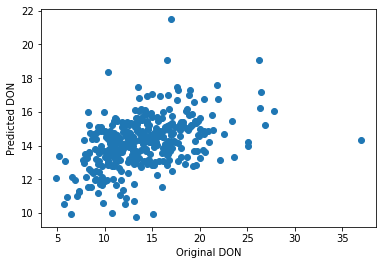

In [14]:
import matplotlib.pyplot as plt
fig = plt.scatter(don_true, don_predicted)
plt.xlabel('Original DON')
plt.ylabel('Predicted DON')
plt.show()

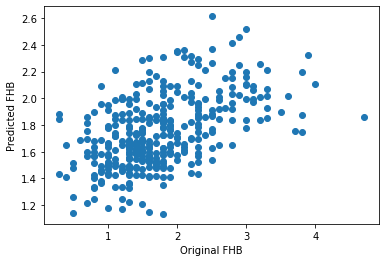

In [15]:
import matplotlib.pyplot as plt
fig = plt.scatter(fhb_true, fhb_predicted)
plt.xlabel('Original FHB')
plt.ylabel('Predicted FHB')
plt.show()